# Training the most naive implementation of solving the bit sequence problem.

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{2^n}$ vector of the $Q$-values
    * The index corresponds to integer $\geq 0$ representing the bit sequence using binary to integer (e.g. $00011 \sim 2+1=3$)
    * So $\text{model}(s)[a]$ will be the $Q$-value
 * Architecture: Simple MLP

## Training method
Simple DQN with replay
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent). The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.

In [1]:
from src.environments.env_bit_sequence_naive import NaiveBitSequenceEnv
from src.agents.agent_dqn import DQNAgent
from src.models.model_dqn_naive import NaiveDQNNetwork
from src.models.buffer_naive import BufferNaive

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0")

def train_DQN_agent(n: int, device: torch.device,
    episodes: int=1000, num_explore_agents: int=16, num_valid_agents: int=128,
    batch_size: int=128) -> None:

    # initialize environment, model and agent
    env = NaiveBitSequenceEnv(n, device)
    model = NaiveDQNNetwork(n)
    model.to(device)
    buffer = BufferNaive(n)
    agent = DQNAgent(model=model, buffer=buffer, device=device,
                    action_space_size=2 ** n)

    success_rates = []
    steps_to_success = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)

        # let agent act for at most 50 steps
        for _ in range(50):  # max time steps
            with torch.no_grad():
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                agent.remember(state[prev_step_ongoing, :].cpu().numpy(), action[prev_step_ongoing].cpu().numpy(),
                               reward[prev_step_ongoing].cpu().numpy(), next_state[prev_step_ongoing, :].cpu().numpy(), done[prev_step_ongoing].cpu().numpy())
                state = next_state
                if done.all():
                    break
        
        # replay to update Q network
        agent.replay(batch_size=batch_size)

        # now run the agent for at most 50 steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for _ in range(50):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)

        if (e + 1) % 100 == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(1, 2, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.show()

# Experiments

$n=2$

Initialized NaiveBitSequenceEnv with n = 2. Randomly picked target: tensor([0, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 101/1000 [00:07<01:18, 11.47it/s]

Episode: 99/1000, Epsilon: 0.6149486215357263, Success rate: 0.40, Avg steps to success: 31.08


 20%|██        | 201/1000 [00:16<01:12, 11.02it/s]

Episode: 199/1000, Epsilon: 0.37251769488706843, Success rate: 0.52, Avg steps to success: 25.22


 30%|███       | 301/1000 [00:27<01:21,  8.55it/s]

Episode: 299/1000, Epsilon: 0.22566020663225933, Success rate: 0.45, Avg steps to success: 28.73


 41%|████      | 409/1000 [00:32<00:09, 59.95it/s]

Episode: 399/1000, Epsilon: 0.13669828187021155, Success rate: 1.00, Avg steps to success: 1.23


 51%|█████     | 510/1000 [00:34<00:07, 65.93it/s]

Episode: 499/1000, Epsilon: 0.08280777787605056, Success rate: 1.00, Avg steps to success: 1.24


 61%|██████    | 608/1000 [00:35<00:05, 70.35it/s]

Episode: 599/1000, Epsilon: 0.050162503748802344, Success rate: 1.00, Avg steps to success: 1.24


 71%|███████   | 707/1000 [00:37<00:04, 70.82it/s]

Episode: 699/1000, Epsilon: 0.03038696179137978, Success rate: 1.00, Avg steps to success: 1.20


 81%|████████  | 811/1000 [00:38<00:02, 68.70it/s]

Episode: 799/1000, Epsilon: 0.018407523107991184, Success rate: 1.00, Avg steps to success: 1.24


 91%|█████████ | 908/1000 [00:40<00:01, 72.34it/s]

Episode: 899/1000, Epsilon: 0.011150733307840981, Success rate: 1.00, Avg steps to success: 1.23


100%|██████████| 1000/1000 [00:41<00:00, 24.20it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 1.34


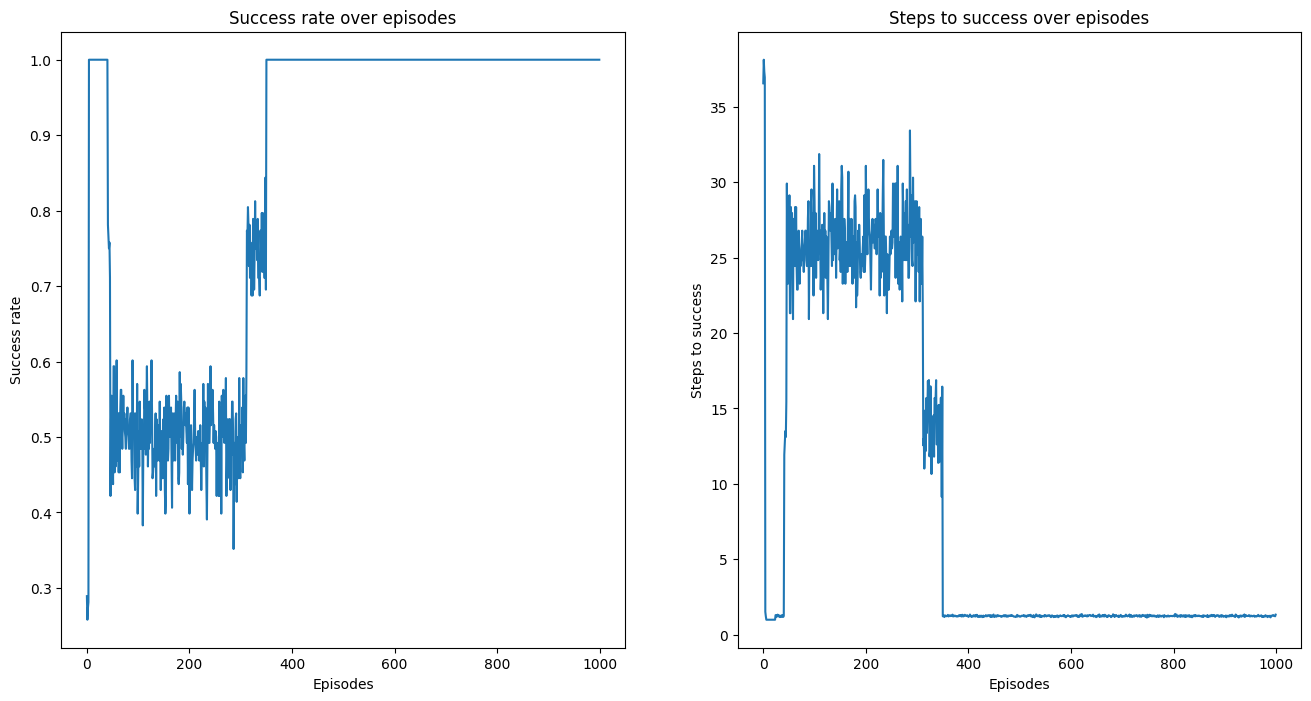

In [2]:
train_DQN_agent(2, device=device)

$n=3$

Initialized NaiveBitSequenceEnv with n = 3. Randomly picked target: tensor([1, 1, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 101/1000 [00:12<02:24,  6.24it/s]

Episode: 99/1000, Epsilon: 0.6088145090359074, Success rate: 0.13, Avg steps to success: 44.36


 20%|██        | 201/1000 [00:29<02:06,  6.30it/s]

Episode: 199/1000, Epsilon: 0.36880183088056995, Success rate: 0.18, Avg steps to success: 42.02


 30%|███       | 305/1000 [00:43<00:28, 24.14it/s]

Episode: 299/1000, Epsilon: 0.22340924607110255, Success rate: 1.00, Avg steps to success: 1.69


 41%|████      | 407/1000 [00:45<00:12, 46.02it/s]

Episode: 399/1000, Epsilon: 0.1353347165085562, Success rate: 1.00, Avg steps to success: 1.59


 51%|█████     | 507/1000 [00:47<00:09, 51.19it/s]

Episode: 499/1000, Epsilon: 0.08198177029173696, Success rate: 1.00, Avg steps to success: 1.71


 61%|██████    | 608/1000 [00:49<00:07, 50.07it/s]

Episode: 599/1000, Epsilon: 0.04966213277390804, Success rate: 1.00, Avg steps to success: 1.55


 71%|███████   | 708/1000 [00:51<00:06, 47.99it/s]

Episode: 699/1000, Epsilon: 0.030083851847510768, Success rate: 1.00, Avg steps to success: 1.76


 81%|████████  | 811/1000 [00:53<00:03, 51.38it/s]

Episode: 799/1000, Epsilon: 0.018223908064988973, Success rate: 1.00, Avg steps to success: 1.66


 91%|█████████ | 907/1000 [00:55<00:01, 54.41it/s]

Episode: 899/1000, Epsilon: 0.011039504743095268, Success rate: 1.00, Avg steps to success: 1.57


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 1.67


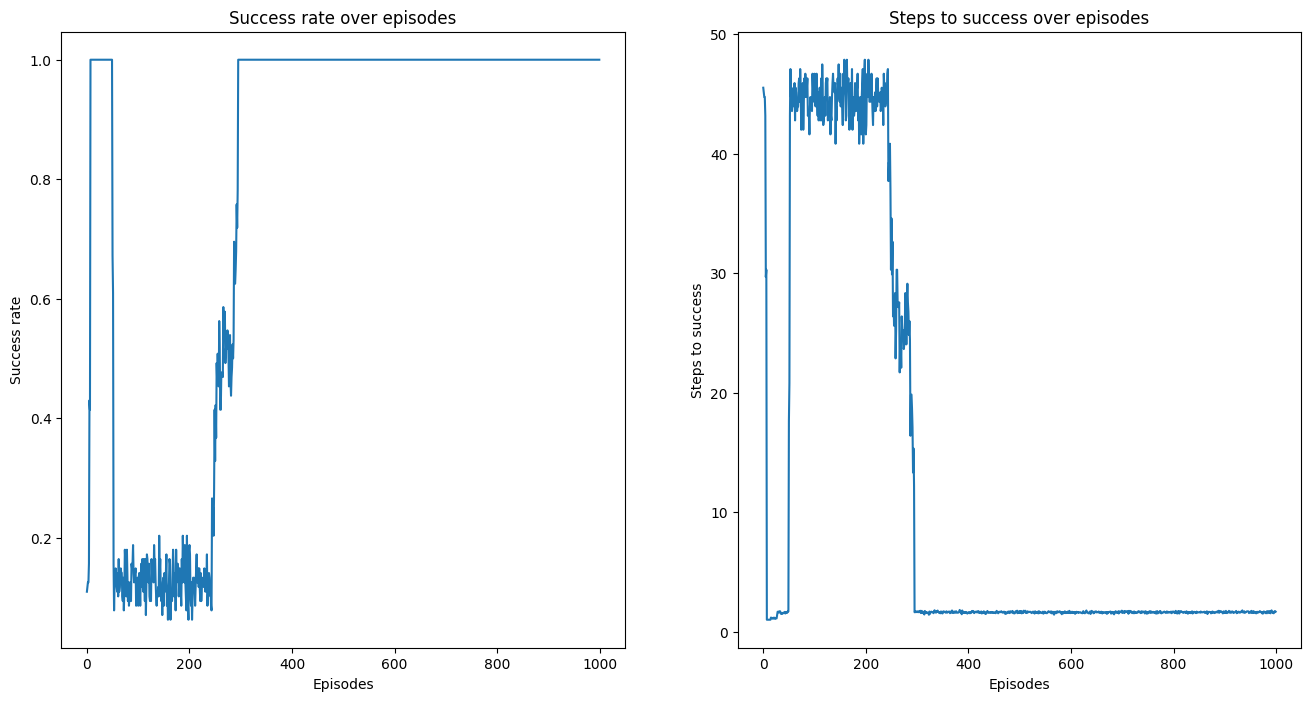

In [3]:
train_DQN_agent(3, device=device)

$n=6$

Initialized NaiveBitSequenceEnv with n = 6. Randomly picked target: tensor([1, 1, 1, 1, 1, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 100/1000 [00:14<02:22,  6.32it/s]

Episode: 99/1000, Epsilon: 0.6057704364907278, Success rate: 0.97, Avg steps to success: 4.76


 20%|██        | 201/1000 [00:30<02:42,  4.92it/s]

Episode: 199/1000, Epsilon: 0.3669578217261671, Success rate: 0.95, Avg steps to success: 5.91


 30%|███       | 304/1000 [00:42<00:30, 22.75it/s]

Episode: 299/1000, Epsilon: 0.22229219984074702, Success rate: 1.00, Avg steps to success: 3.30


 40%|████      | 403/1000 [00:46<00:23, 24.96it/s]

Episode: 399/1000, Epsilon: 0.1346580429260134, Success rate: 1.00, Avg steps to success: 3.42


 50%|█████     | 503/1000 [00:49<00:18, 26.59it/s]

Episode: 499/1000, Epsilon: 0.08157186144027828, Success rate: 1.00, Avg steps to success: 3.38


 60%|██████    | 603/1000 [00:53<00:13, 29.11it/s]

Episode: 599/1000, Epsilon: 0.0494138221100385, Success rate: 1.00, Avg steps to success: 3.16


 70%|███████   | 704/1000 [00:56<00:09, 32.11it/s]

Episode: 699/1000, Epsilon: 0.029933432588273214, Success rate: 1.00, Avg steps to success: 3.26


 81%|████████  | 806/1000 [00:59<00:05, 33.70it/s]

Episode: 799/1000, Epsilon: 0.018132788524664028, Success rate: 1.00, Avg steps to success: 3.00


 90%|█████████ | 903/1000 [01:03<00:03, 30.33it/s]

Episode: 899/1000, Epsilon: 0.01098430721937979, Success rate: 1.00, Avg steps to success: 3.47


100%|██████████| 1000/1000 [01:07<00:00, 14.92it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 3.24


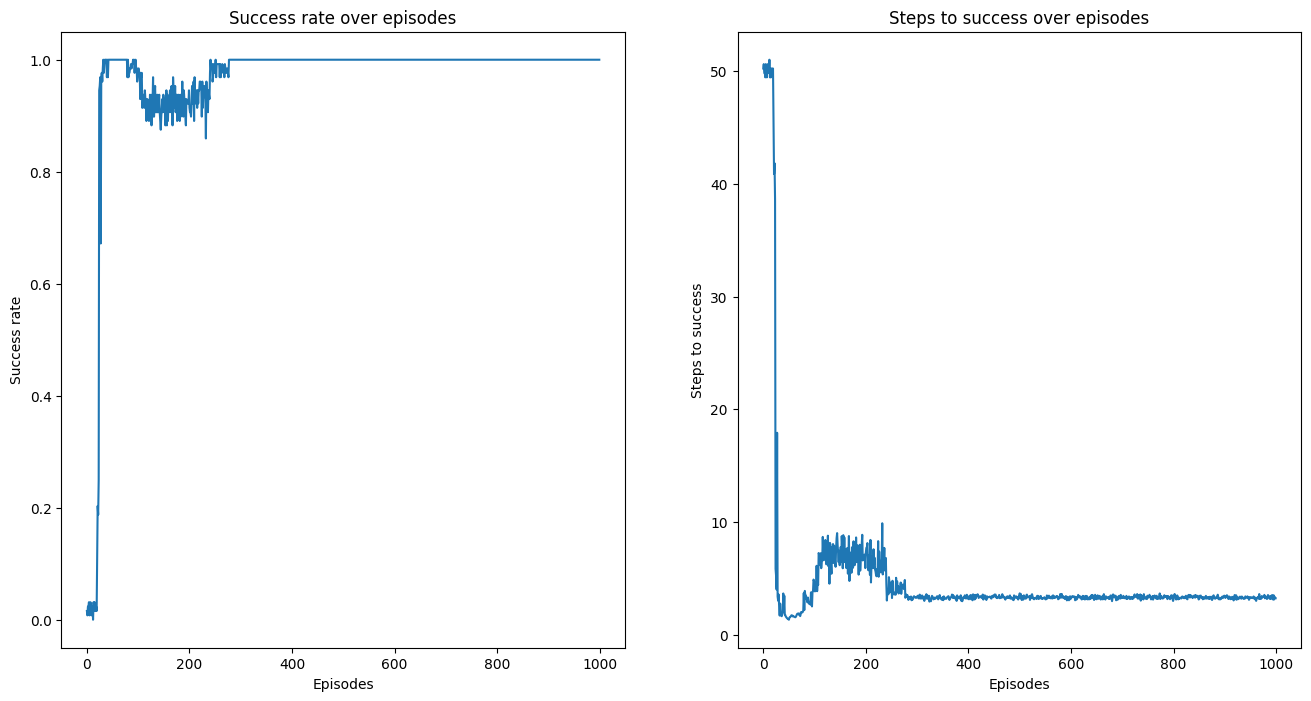

In [4]:
train_DQN_agent(6, device=device)

$n=10$

Unsurprisingly, it is harder for the agent to reach the target

Initialized NaiveBitSequenceEnv with n = 10. Randomly picked target: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 101/1000 [00:21<02:36,  5.75it/s]

Episode: 99/1000, Epsilon: 0.6057704364907278, Success rate: 0.94, Avg steps to success: 16.41


 20%|██        | 200/1000 [00:34<01:17, 10.37it/s]

Episode: 199/1000, Epsilon: 0.3669578217261671, Success rate: 0.88, Avg steps to success: 10.05


 30%|███       | 301/1000 [00:49<02:01,  5.77it/s]

Episode: 299/1000, Epsilon: 0.22229219984074702, Success rate: 0.93, Avg steps to success: 15.56


 40%|████      | 401/1000 [01:05<01:32,  6.47it/s]

Episode: 399/1000, Epsilon: 0.1346580429260134, Success rate: 0.30, Avg steps to success: 38.60


 50%|█████     | 501/1000 [01:21<01:20,  6.17it/s]

Episode: 499/1000, Epsilon: 0.08157186144027828, Success rate: 0.11, Avg steps to success: 45.98


 60%|██████    | 601/1000 [01:39<01:08,  5.83it/s]

Episode: 599/1000, Epsilon: 0.0494138221100385, Success rate: 0.33, Avg steps to success: 37.61


 70%|███████   | 701/1000 [01:56<00:56,  5.25it/s]

Episode: 699/1000, Epsilon: 0.029933432588273214, Success rate: 0.13, Avg steps to success: 45.12


 80%|████████  | 801/1000 [02:14<00:33,  5.88it/s]

Episode: 799/1000, Epsilon: 0.018132788524664028, Success rate: 0.09, Avg steps to success: 46.59


 90%|█████████ | 901/1000 [02:32<00:16,  5.84it/s]

Episode: 899/1000, Epsilon: 0.01098430721937979, Success rate: 0.08, Avg steps to success: 47.32


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 0.07, Avg steps to success: 47.70


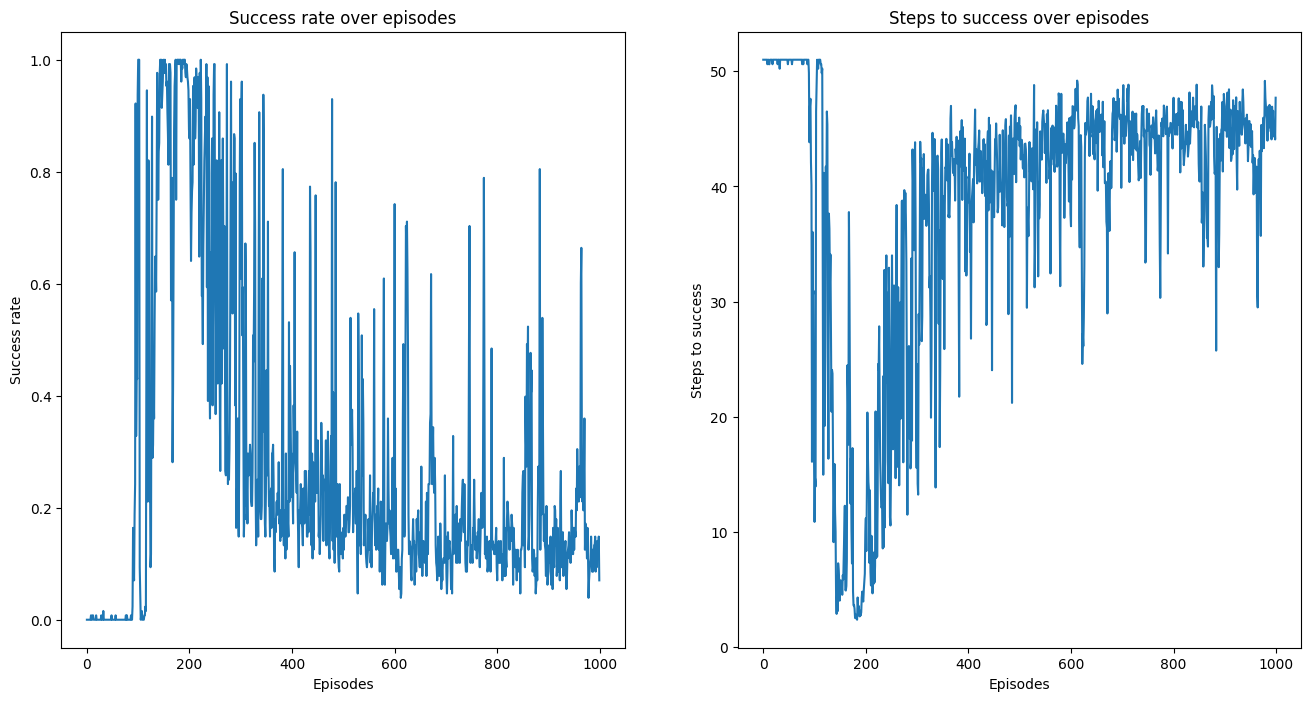

In [5]:
train_DQN_agent(10, device=device)

$n=15$

The agent cannot consistently reach the target even by giving more training epochs.

Initialized NaiveBitSequenceEnv with n = 15. Randomly picked target: tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


  0%|          | 0/4000 [00:00<?, ?it/s]

  3%|▎         | 101/4000 [00:19<10:59,  5.91it/s]

Episode: 99/4000, Epsilon: 0.6057704364907278, Success rate: 0.00, Avg steps to success: 51.00


  5%|▌         | 201/4000 [00:37<11:08,  5.68it/s]

Episode: 199/4000, Epsilon: 0.3669578217261671, Success rate: 0.00, Avg steps to success: 51.00


  8%|▊         | 301/4000 [00:57<12:41,  4.86it/s]

Episode: 299/4000, Epsilon: 0.22229219984074702, Success rate: 0.00, Avg steps to success: 51.00


 10%|█         | 401/4000 [01:18<11:42,  5.12it/s]

Episode: 399/4000, Epsilon: 0.1346580429260134, Success rate: 0.00, Avg steps to success: 51.00


 13%|█▎        | 501/4000 [01:38<11:19,  5.15it/s]

Episode: 499/4000, Epsilon: 0.08157186144027828, Success rate: 0.00, Avg steps to success: 51.00


 15%|█▌        | 601/4000 [01:59<11:18,  5.01it/s]

Episode: 599/4000, Epsilon: 0.0494138221100385, Success rate: 0.00, Avg steps to success: 51.00


 18%|█▊        | 701/4000 [02:20<11:06,  4.95it/s]

Episode: 699/4000, Epsilon: 0.029933432588273214, Success rate: 0.00, Avg steps to success: 51.00


 20%|██        | 801/4000 [02:41<10:58,  4.86it/s]

Episode: 799/4000, Epsilon: 0.018132788524664028, Success rate: 0.00, Avg steps to success: 51.00


 23%|██▎       | 901/4000 [03:03<11:10,  4.62it/s]

Episode: 899/4000, Epsilon: 0.01098430721937979, Success rate: 0.00, Avg steps to success: 51.00


 25%|██▌       | 1001/4000 [03:24<09:32,  5.24it/s]

Episode: 999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 28%|██▊       | 1101/4000 [03:43<09:02,  5.35it/s]

Episode: 1099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 30%|███       | 1201/4000 [04:03<08:45,  5.33it/s]

Episode: 1199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 33%|███▎      | 1301/4000 [04:23<08:42,  5.16it/s]

Episode: 1299/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 35%|███▌      | 1400/4000 [04:43<08:46,  4.94it/s]

Episode: 1399/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 38%|███▊      | 1501/4000 [05:05<08:18,  5.01it/s]

Episode: 1499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 40%|████      | 1601/4000 [05:25<07:33,  5.29it/s]

Episode: 1599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 43%|████▎     | 1701/4000 [05:44<06:54,  5.55it/s]

Episode: 1699/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 45%|████▌     | 1800/4000 [06:04<07:35,  4.83it/s]

Episode: 1799/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 48%|████▊     | 1900/4000 [06:27<09:18,  3.76it/s]

Episode: 1899/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 50%|█████     | 2000/4000 [06:52<08:56,  3.73it/s]

Episode: 1999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 52%|█████▎    | 2100/4000 [07:22<07:49,  4.05it/s]

Episode: 2099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 55%|█████▌    | 2200/4000 [07:49<07:32,  3.97it/s]

Episode: 2199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 57%|█████▊    | 2300/4000 [08:21<08:11,  3.46it/s]

Episode: 2299/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 60%|██████    | 2400/4000 [08:51<07:44,  3.44it/s]

Episode: 2399/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 62%|██████▎   | 2500/4000 [09:21<07:32,  3.31it/s]

Episode: 2499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 65%|██████▌   | 2600/4000 [09:52<07:35,  3.07it/s]

Episode: 2599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 68%|██████▊   | 2700/4000 [10:21<06:55,  3.13it/s]

Episode: 2699/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 70%|███████   | 2800/4000 [10:53<06:56,  2.88it/s]

Episode: 2799/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 72%|███████▎  | 2900/4000 [11:22<05:00,  3.66it/s]

Episode: 2899/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 75%|███████▌  | 3000/4000 [11:53<05:10,  3.22it/s]

Episode: 2999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 78%|███████▊  | 3100/4000 [12:25<05:14,  2.86it/s]

Episode: 3099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 80%|████████  | 3200/4000 [12:53<03:24,  3.91it/s]

Episode: 3199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 82%|████████▎ | 3300/4000 [13:22<02:59,  3.89it/s]

Episode: 3299/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 85%|████████▌ | 3400/4000 [13:53<03:17,  3.03it/s]

Episode: 3399/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 88%|████████▊ | 3500/4000 [14:28<02:38,  3.15it/s]

Episode: 3499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 90%|█████████ | 3600/4000 [14:58<01:59,  3.35it/s]

Episode: 3599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 92%|█████████▎| 3700/4000 [15:29<01:27,  3.41it/s]

Episode: 3699/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 95%|█████████▌| 3800/4000 [15:56<00:54,  3.67it/s]

Episode: 3799/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 98%|█████████▊| 3900/4000 [16:24<00:27,  3.67it/s]

Episode: 3899/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


100%|██████████| 4000/4000 [16:52<00:00,  3.95it/s]

Episode: 3999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


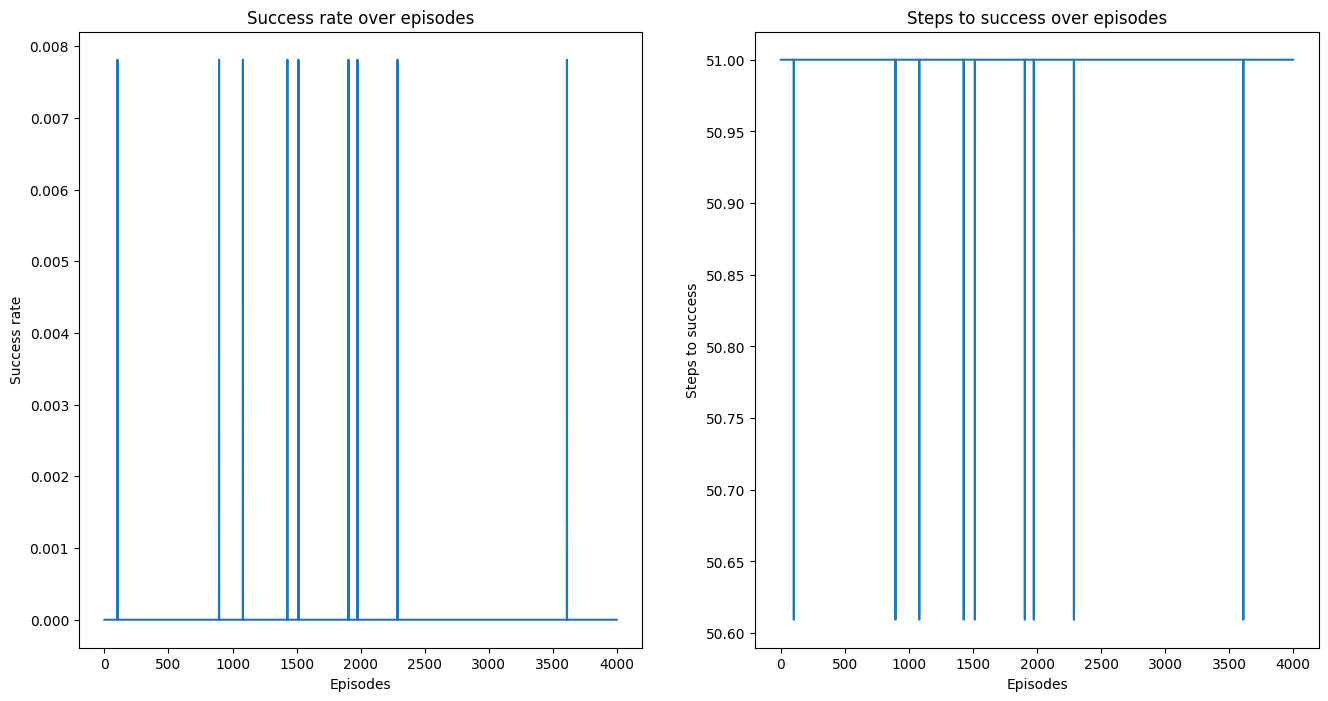

In [10]:
train_DQN_agent(15, device=device, episodes=4000)